In [1]:
import mne
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from autoreject import AutoReject
from mne.datasets import sample

In [2]:
data_path = mne.datasets.erp_core.data_path()
raw_fname = f"{data_path}/ERP-CORE_Subject-001_Task-Flankers_eeg.fif"
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /u/kroma/mne_data/MNE-ERP-CORE-data/ERP-CORE_Subject-001_Task-Flankers_eeg.fif...


/u/kroma/conda-envs/m4d/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


    Range : 0 ... 935935 =      0.000 ...   913.999 secs
Ready.
Reading 0 ... 935935  =      0.000 ...   913.999 secs...


In [3]:
# get events
events, event_dict = mne.events_from_annotations(raw)
# only eeg
raw.pick("eeg")
# minimal preprocessing
raw.filter(l_freq=0.1, # hpf
           h_freq=20, # lpf
           n_jobs=-1,
           fir_design='firwin')

Used Annotations descriptions: ['response/left', 'response/right', 'stimulus/compatible/target_left', 'stimulus/compatible/target_right', 'stimulus/incompatible/target_left', 'stimulus/incompatible/target_right']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 33793 samples (33.001 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 144 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:  1.3min remaining:  5.1min
[Parallel(n_jobs=-1)]: Done  13 out of  30 | elapsed:  1.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  20 out of  30 | elapsed:  1.4min remaining:   42.2s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  1.4min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


<Raw | ERP-CORE_Subject-001_Task-Flankers_eeg.fif, 30 x 935936 (914.0 s), ~214.3 MB, data loaded>

In [4]:
# create epochs, not optimal baseline for this experiment, but this is not of interest here
epochs = mne.Epochs(raw.copy(),
                    events=events,
                    #event_id=event_dict,
                    tmin=-0.6,
                    tmax=0.6,
                    baseline=(-0.6,-0.4),
                    detrend=None,
                    proj=False,
                    reject_by_annotation=False,
                    preload=True)
epochs = epochs[["1","2"]]

Not setting metadata
802 matching events found
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 802 events and 1229 original time points ...
0 bad epochs dropped


In [5]:
# function to iterate over AR

def runAR(epochs, seed_sampling=1, seed_ar=1):
    ar = AutoReject(n_jobs=-1,
                    cv=5,
                    random_state=seed_ar,
                    verbose=False) # supress output
    np.random.seed(seed_sampling)
    indices = np.random.choice(len(epochs), int(len(epochs) * 0.25), replace=False) # take 25 % of epochs for estimation (i.e., similarly low number than in tutorial)
    epochs_sample = epochs[indices].copy()
    ar.fit(epochs_sample)

    epochs_clean, reject_log = ar.transform(epochs, return_log=True)

    # uncomment, if you want to see which trials and channels get rejected and interpolated
    #rej_plot = reject_log.plot('horizontal', show=True)

    return len(epochs_clean) / len(epochs), reject_log # fraction of maintained epochs


In [7]:
percent_maintained1 = []
rej_logs1 = []

# make the loop in a parallel fashion
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(num_cores)

# create shared list


# Initialize two empty shared lists
list1 = []
list2 = []

percent_maintained1 = Parallel(n_jobs=20)(delayed(runAR)(epochs, seed_sampling=1, seed_ar=seed) for seed in range(1,20))

# Unpack results into two separate lists
list1, list2 = zip(*percent_maintained1)

# If needed, convert the zipped tuples back to lists
list1 = list(list1)
list2 = list(list2)


144


Dropped 1 epoch: 331
Dropped 27 epochs: 192, 200, 233, 246, 247, 284, 285, 288, 304, 305, 315, 317, 331, 335, 341, 342, 343, 345, 347, 348, 349, 351, 353, 360, 378, 381, 391
Dropped 210 epochs: 1, 8, 10, 14, 19, 23, 25, 29, 33, 35, 41, 43, 44, 45, 47, 50, 51, 55, 59, 60, 63, 66, 67, 70, 73, 79, 83, 88, 89, 90, 94, 97, 98, 99, 104, 105, 107, 109, 112, 113, 114, 115, 118, 119, 124, 125, 131, 134, 135, 138, 141, 142, 143, 147, 150, 152, 156, 158, 160, 161, 167, 168, 173, 175, 180, 183, 185, 192, 193, 197, 198, 199, 200, 203, 205, 206, 207, 208, 209, 210, 218, 220, 221, 224, 226, 230, 233, 234, 237, 238, 239, 243, 245, 246, 247, 248, 249, 250, 251, 253, 255, 256, 257, 259, 260, 261, 262, 263, 264, 265, 267, 268, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 281, 283, 284, 285, 288, 290, 291, 293, 294, 297, 299, 300, 303, 304, 305, 306, 307, 308, 309, 310, 314, 315, 316, 317, 318, 320, 321, 324, 325, 327, 328, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 34

In [8]:
list1

[0.8830845771144279,
 0.47761194029850745,
 0.9029850746268657,
 0.9054726368159204,
 0.8980099502487562,
 0.9800995024875622,
 0.8955223880597015,
 0.9328358208955224,
 1.0,
 0.8407960199004975,
 0.9228855721393034,
 0.8656716417910447,
 0.9975124378109452,
 0.8905472636815921,
 0.8283582089552238,
 0.9029850746268657,
 0.9378109452736318,
 0.8084577114427861,
 0.8258706467661692]

In [16]:
rejected_trials1 = [i.bad_epochs for i in list2]
rejected_trials1 = np.vstack(rejected_trials1)
rejected_trials1

array([[False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
# percent_maintained2 = []
# rej_logs2 = []

# for seed in range(1,20):
#     a, b = runAR(epochs, seed_sampling=seed, seed_ar=1)
#     percent_maintained2.append(a)
#     rej_logs2.append(b)

In [28]:
percent_maintained2 = []
rej_logs2 = []

# Initialize two empty shared lists
list1a = []
list2a = []

percent_maintained2 = Parallel(n_jobs=20)(delayed(runAR)(epochs, seed_sampling=seed, seed_ar=1) for seed in range(1,20))

# Unpack results into two separate lists
list1a, list2a = zip(*percent_maintained2)

# If needed, convert the zipped tuples back to lists
list1a = list(list1a)
list2a = list(list2a)


Dropped 72 epochs: 66, 79, 113, 134, 135, 142, 152, 175, 192, 200, 203, 208, 226, 233, 246, 247, 248, 249, 250, 256, 257, 260, 261, 262, 267, 270, 271, 272, 273, 280, 284, 285, 288, 304, 305, 306, 307, 315, 317, 318, 321, 331, 332, 333, 335, 336, 338, 340, 341, 342, 343, 345, 346, 347, 348, 349, 351, 353, 357, 360, 361, 362, 363, 365, 366, 368, 378, 381, 386, 387, 391, 394
Dropped 36 epochs: 66, 192, 200, 226, 233, 246, 247, 248, 273, 284, 285, 288, 304, 305, 306, 315, 331, 332, 335, 336, 341, 342, 343, 345, 347, 348, 349, 351, 353, 357, 360, 361, 366, 378, 381, 391
Dropped 39 epochs: 66, 134, 192, 200, 226, 233, 246, 247, 248, 273, 284, 285, 288, 304, 305, 306, 315, 317, 318, 324, 331, 335, 336, 341, 342, 343, 345, 346, 347, 348, 349, 353, 360, 361, 368, 378, 381, 388, 391
Dropped 45 epochs: 66, 175, 192, 200, 226, 233, 246, 247, 248, 267, 273, 284, 285, 288, 300, 304, 305, 307, 315, 317, 318, 321, 331, 332, 335, 336, 341, 342, 343, 345, 346, 347, 348, 349, 351, 353, 357, 360, 361, 36

In [30]:
rejected_trials2 = [i.bad_epochs for i in list2a]
rejected_trials2 = np.vstack(rejected_trials2)
rejected_trials2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False,  True]])

# plot

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


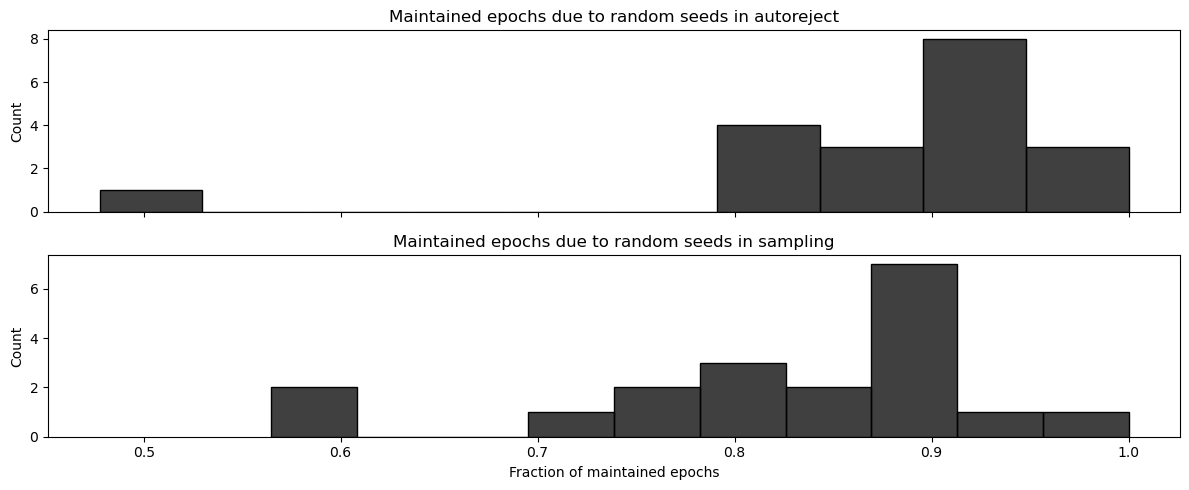

In [43]:
# plot histogram of number of rejected trials (list1, list1a), vertical subplots
# make it black bars



fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
sns.histplot(list1, ax=axs[0], bins=10, color='black')
axs[0].set_title("Maintained epochs due to random seeds in autoreject")
axs[0].set_xlabel("Fraction of maintained epochs")
axs[0].set_ylabel("Count")
sns.histplot(list1a, ax=axs[1], bins=10, color='black')
axs[1].set_title("Maintained epochs due to random seeds in sampling")
axs[1].set_xlabel("Fraction of maintained epochs")
axs[1].set_ylabel("Count")
plt.tight_layout()


# save
plt.savefig("maintained_epochs.png", dpi=300)

plt.show()         



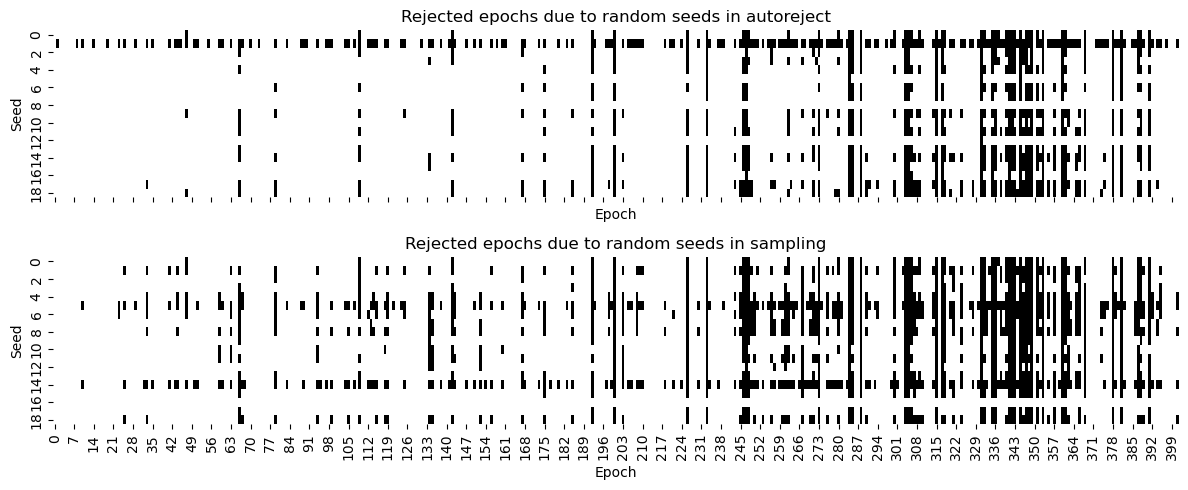

In [44]:
# combine both plots vertically

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

sns.heatmap(rejected_trials1, cmap='Greys', cbar=False, linewidths=0, ax=ax1)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Seed")
ax1.set_title("Rejected epochs due to random seeds in autoreject")

sns.heatmap(rejected_trials2, cmap='Greys', cbar=False, linewidths=0, ax=ax2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Seed")
plt.title("Rejected epochs due to random seeds in sampling")

fig.tight_layout()
plt.savefig("rejected_epochs.png", dpi=300)
plt.show()

In [40]:
pwd

'/raven/u/kroma/m4d/notebooks'